In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import preprocessing
import time
import itertools
from sklearn.cluster import KMeans
from scipy import stats
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline

In [2]:
industry_df = pd.read_csv('Data/movie_industry.csv', encoding='latin-1')
oscar_df = pd.read_csv('Data/the_oscar_award.csv', encoding='latin-1')
links_df = pd.read_csv('Data/movie_lense/links.csv')
tags_df = pd.read_csv('Data/movie_lense/tags.csv')
genome_scores_df = pd.read_csv('Data/movie_lense/genome-scores.csv')
movies_df = pd.read_csv('Data/movie_lense/movies.csv')
ratings_df = pd.read_csv('Data/movie_lense/ratings.csv')
genome_tags_df = pd.read_csv('Data/movie_lense/genome-tags.csv')

In [4]:
tgsdf = genome_scores_df.pivot(index='movieId',columns='tagId',values='relevance')
genome_tags_dict = dict(zip(genome_tags_df['tagId'],genome_tags_df['tag']))
movie_names_dict = dict(zip(movies_df['movieId'],movies_df['title']))
tags = genome_tags_df['tag'].values
# genome_tags_dict
# movie_names_dict
movies_df
movie_tags_df = tgsdf.rename(genome_tags_dict,axis='columns')
movie_tags_thresh_df = movie_tags_df.copy()
thresh = 0.8
movie_tags_thresh_df[movie_tags_thresh_df<thresh] = 0
movie_tags_thresh_df[movie_tags_thresh_df>thresh] = 1
# movie_tags_df.sum()
movie_tags_df

tagId,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,...,0.03775,0.02250,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,...,0.04775,0.02050,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,...,0.05800,0.02375,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,...,0.04900,0.03275,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500
5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,...,0.05375,0.02625,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185435,0.10625,0.10775,0.03025,0.05650,0.23175,0.04575,0.05175,0.44700,0.19875,0.04025,...,0.34725,0.03125,0.03500,0.12125,0.32200,0.08200,0.03325,0.02425,0.13725,0.02625
185585,0.04250,0.04175,0.06475,0.07625,0.08500,0.03800,0.03425,0.16850,0.02525,0.03525,...,0.04325,0.05850,0.03050,0.02750,0.21850,0.04525,0.03550,0.02550,0.17475,0.03100
186587,0.08950,0.09125,0.05075,0.04900,0.19475,0.04500,0.03125,0.17275,0.07850,0.02475,...,0.06475,0.04500,0.04000,0.01975,0.22075,0.15125,0.06150,0.04300,0.20800,0.03925


In [7]:
movie_tags_dfT = movie_tags_df.T
movie_tags_dfT

movieId,1,2,3,4,5,6,7,8,9,10,...,184987,184997,185029,185135,185425,185435,185585,186587,187593,187595
tagId,,,,,,,,,,,,,,,,,,,,,
007,0.02900,0.03625,0.04150,0.03350,0.04050,0.02925,0.04775,0.03125,0.03225,0.99950,...,0.01975,0.03450,0.04125,0.30750,0.03875,0.10625,0.04250,0.08950,0.05450,0.10150
007 (series),0.02375,0.03625,0.04950,0.03675,0.05175,0.02575,0.05075,0.03750,0.03550,1.00000,...,0.01650,0.02475,0.04100,0.37300,0.03175,0.10775,0.04175,0.09125,0.05250,0.10400
18th century,0.05425,0.08275,0.03000,0.04275,0.03600,0.02700,0.13400,0.08050,0.02150,0.03050,...,0.13200,0.07375,0.08350,0.17900,0.06225,0.03025,0.06475,0.05075,0.07200,0.04950
1920s,0.06875,0.08175,0.09525,0.02625,0.04625,0.03450,0.08825,0.03150,0.01650,0.05150,...,0.08500,0.19500,0.11925,0.15975,0.02650,0.05650,0.07625,0.04900,0.15050,0.07025
1930s,0.16000,0.10200,0.04525,0.05250,0.05500,0.06825,0.09550,0.05100,0.02350,0.07850,...,0.09000,0.22150,0.21775,0.30775,0.06700,0.23175,0.08500,0.19475,0.23125,0.22875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
writing,0.04550,0.02700,0.03250,0.05225,0.02050,0.09250,0.04475,0.06400,0.01525,0.06225,...,0.06350,0.18100,0.17875,0.18975,0.05525,0.08200,0.04525,0.15125,0.13875,0.10700
wuxia,0.02000,0.01825,0.01625,0.01500,0.01500,0.03225,0.01800,0.01525,0.01150,0.02000,...,0.12075,0.03700,0.06650,0.04550,0.04775,0.03325,0.03550,0.06150,0.04525,0.05850
wwii,0.03850,0.01225,0.02125,0.01600,0.01550,0.02150,0.01000,0.01450,0.00700,0.01400,...,0.02250,0.03300,0.05625,0.20150,0.00950,0.02425,0.02550,0.04300,0.05775,0.03800


In [8]:
# Make matrix of euclidian distance b/w each movie
dist = euclidean_distances(movie_tags_dfT,movie_tags_dfT)

In [11]:
np.fill_diagonal(dist,np.median(dist)) # Make all diags median so they doont influence min or max
print(dist.shape)
dist

(1128, 1128)


array([[22.032742  ,  5.55510417, 16.20494673, ..., 18.12770324,
        16.84419152, 13.11948265],
       [ 5.55510417, 22.032742  , 15.66095888, ..., 17.76083211,
        16.46228393, 12.45268829],
       [16.20494673, 15.66095888, 22.032742  , ..., 20.73819175,
        18.59243795, 17.42772658],
       ...,
       [18.12770324, 17.76083211, 20.73819175, ..., 22.032742  ,
        22.30721819, 19.27148638],
       [16.84419152, 16.46228393, 18.59243795, ..., 22.30721819,
        22.032742  , 12.38796766],
       [13.11948265, 12.45268829, 17.42772658, ..., 19.27148638,
        12.38796766, 22.032742  ]])

In [ ]:
# Pairs with small tag distance mostly appear together and are redundant, can prune
# If we sum all of the distance for a given tag, the ones with the smallest sums will be the most common across all movies

In [50]:
tag_sum = movie_tags_dfT.to_numpy().sum(axis=1)

In [51]:
dist_sum = np.sum(dist,axis=1)

0 original 9718.6205
1 mentor 7013.803749999999
2 catastrophe 6364.41175
3 storytelling 6290.753500000001
4 great ending 5961.84775
5 dialogue 5873.6315
6 runaway 5683.943499999999
7 good soundtrack 5549.0235
8 good 5507.9155
9 weird 5480.286
10 melancholic 5427.483749999999
11 story 5397.7245
12 great 5306.612
13 vengeance 5297.9875
14 chase 5216.0635
15 brutality 5213.040499999999
16 criterion 5101.646000000001
17 drama 4958.8265
18 greed 4934.101250000001
19 adaptation 4784.7635
20 culture clash 4744.1415
21 life philosophy 4743.60425
22 visually appealing 4739.0824999999995
23 cinematography 4721.1185000000005
24 predictable 4684.27775
25 imdb top 250 4520.75075
26 great acting 4505.69725
27 talky 4493.03075
28 fantasy world 4486.2122500000005
29 pg-13 4452.400500000001
30 twists &amp; turns 4412.48875
31 redemption 4384.9065
32 clever 4368.56025
33 betrayal 4322.047500000001
34 destiny 4317.19475
35 pornography 4289.8125
36 suspense 4280.558
37 not funny 4266.3675
38 stylized 4236

(0.0, 50.0)

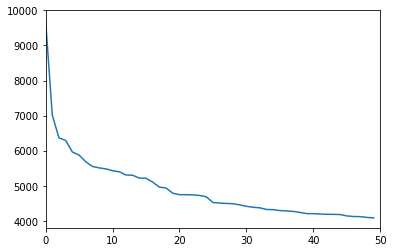

In [58]:
# nsmall=10
nlarge=50
# largest_indices = dist_sum.argsort()[-nlarge:]
largest_indices = tag_sum.argsort()[-nlarge:]
largest_indices = largest_indices[::-1]
largest_values = np.sort(tag_sum)[-nlarge:]
largest_values = largest_values[::-1]
for i,(x,v) in enumerate(zip(largest_indices,largest_values)):
    print(i,movie_tags_dfT.index[x],v)

plt.plot(np.arange(50),largest_values)
plt.xlim(0,50)

932500000001
420 george orwell 840.1635000000001
421 19th century 840.665
422 political corruption 856.8125000000001
423 southern theme 858.726
424 death penalty 859.9415
425 arms dealer 860.1300000000001
426 weed 862.54675
427 midlife crisis 866.47875
428 treasure hunt 867.1195
429 caper 867.6090000000002
430 war movie 869.4000000000001
431 1960s 872.782
432 bank robbery 873.66625
433 ghosts 874.3212500000001
434 paris 877.6305
435 spies 878.6585
436 motorcycle 881.987
437 vampire human love 887.05125
438 lawyers 887.9675
439 coen bros 888.5150000000001
440 maze 888.72775
441 saturday night live 889.0135
442 isolation 891.92875
443 animal movie 892.6419999999999
444 giant robots 894.135
445 teenagers 894.2005
446 understated 895.1645000000001
447 saturn award (best special effects) 897.9404999999999
448 pg 901.361
449 guns 902.8402500000001
450 good romantic comedies 903.25175
451 jungle 904.9492500000001
452 assassins 910.0955
453 japan 915.18475
454 psychiatrist 916.09625
455 poland

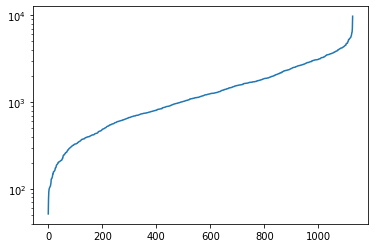

In [82]:
nsmall=1128
# nlarge=50
# largest_indices = dist_sum.argsort()[-nlarge:]
smallest_indices = tag_sum.argsort()[:nsmall]
# smallest_indices = smallest_indices[::-1]
smallest_values = np.sort(tag_sum)[:nsmall]
# smallest_values = smallest_values[::-1]
for i,(x,v) in enumerate(zip(smallest_indices,smallest_values)):
    print(i,movie_tags_dfT.index[x],v)

plt.plot(np.arange(nsmall),smallest_values)
# plt.xlim(0,50)
plt.xscale('linear')
plt.yscale('log')

In [96]:
lo_cut = 300
hi_cut = 1100
drop_indices = np.concatenate((tag_sum.argsort()[:lo_cut],tag_sum.argsort()[hi_cut:]))
# print(drop_indices)
print(len(drop_indices))
tags_to_drop = [movie_tags_dfT.index[x] for x in drop_indices]
tags_to_drop
np.savetxt('Data/tags_to_drop.csv', tags_to_drop, delimiter=',',fmt="%s")

328


In [34]:
x, y = np.unravel_index(dist.argmin(), dist.shape)
print(x,y)
print(dist.min())
print(movie_tags_dfT.index[x])
print(movie_tags_dfT.index[y])

656 975
1.59597070775139
miyazaki
studio ghibli


In [21]:
x, y = np.unravel_index(dist.argmax(), dist.shape)
print(dist.max())
print(movie_tags_dfT.index[x])
print(movie_tags_dfT.index[y])

84.79052645601077
hannibal lecter
original


(array([ 44678., 362026., 473580., 267202.,  93408.,  25258.,   3788.,
           716.,    634.,   1094.]),
 array([ 1.59597071,  9.91542628, 18.23488186, 26.55433743, 34.87379301,
        43.19324858, 51.51270416, 59.83215973, 68.15161531, 76.47107088,
        84.79052646]),
 &lt;BarContainer object of 10 artists&gt;)

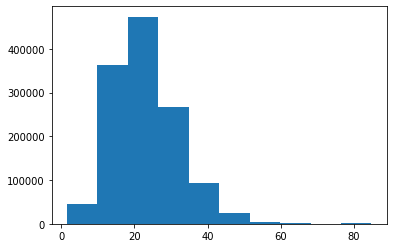

In [22]:
plt.hist(dist.flatten())

(array([499., 332., 145.,  96.,  37.,  13.,   4.,   1.,   0.,   1.]),
 array([  51.68625 , 1018.379675, 1985.0731  , 2951.766525, 3918.45995 ,
        4885.153375, 5851.8468  , 6818.540225, 7785.23365 , 8751.927075,
        9718.6205  ]),
 &lt;BarContainer object of 10 artists&gt;)

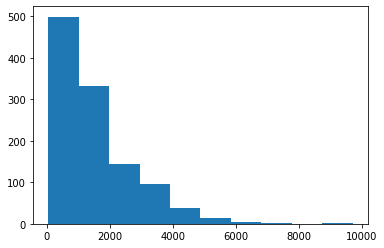

In [79]:
plt.hist(tag_sum.flatten())

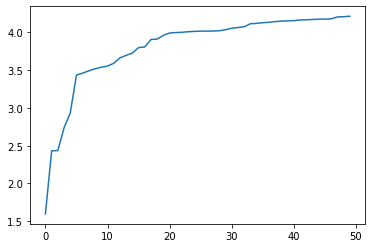

Tag 1:miyazaki, Tag 2:studio ghibli
Tag 1:spock, Tag 2:star trek
Tag 1:vampire, Tag 2:vampires
Tag 1:vietnam, Tag 2:vietnam war
Tag 1:neo-nazis, Tag 2:skinhead
Tag 1:harry potter, Tag 2:tolkien
Tag 1:dr. seuss, Tag 2:roald dahl
Tag 1:figure skating, Tag 2:neil gaiman
Tag 1:aardman, Tag 2:claymation
Tag 1:neil gaiman, Tag 2:roald dahl
Tag 1:hannibal lecter, Tag 2:neil gaiman
Tag 1:emma watson, Tag 2:harry potter
Tag 1:neil gaiman, Tag 2:tolkien
Tag 1:figure skating, Tag 2:hannibal lecter
Tag 1:roald dahl, Tag 2:tolkien
Tag 1:nazi, Tag 2:nazis
Tag 1:pixar, Tag 2:pixar animation
Tag 1:neil gaiman, Tag 2:sophia coppola
Tag 1:neil gaiman, Tag 2:robert ludlum
Tag 1:figure skating, Tag 2:robert ludlum
Tag 1:roald dahl, Tag 2:truman capote
Tag 1:figure skating, Tag 2:roald dahl
Tag 1:neil gaiman, Tag 2:neo-nazis
Tag 1:chris tucker, Tag 2:neil gaiman
Tag 1:figure skating, Tag 2:tolkien
Tag 1:harry potter, Tag 2:roald dahl
Tag 1:super hero, Tag 2:superhero
Tag 1:007, Tag 2:bond
Tag 1:hannibal le

In [73]:
Nsmall = 100
values = np.unique(np.partition(dist, Nsmall, axis=None)[:Nsmall])
plt.plot(np.arange(len(values)),values)
plt.show()
for v in values:
    x,y = np.where(dist == v)[0]
    print("Tag 1:{}, Tag 2:{}".format(movie_tags_dfT.index[x],movie_tags_dfT.index[y]))

